## <center> INTRACRANIAL HEMORRHAGES DATABASE - INFERENTIAL STATISTICS - SURVIVAL ANALYSIS</center>

Notebook

**1. Load dataset**

**2. Define survival variables**

**3. Mantel-Cox test (Log-rank)**

**4. Cox regression**

**5. Conclusions**


### Import libraries

In [1]:
import numpy as np
import pandas as pd
from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from lifelines import KaplanMeierFitter, WeibullAFTFitter
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings

### Silent warnings

In [2]:
warnings.filterwarnings('ignore')

### 1. Load dataset

In [3]:
df= pd.read_hdf('Databases/ICH_database.hdf5')
df_metadata= pd.read_csv('Databases/ICH_database_metadata.csv')
df.head(4)

,patient,sex,hospital,follow_up,final_outcome,nfamily_medhist,tobacco,n_tobacco,drugs,alcohol,...,rdw,mchc,mpv,mch,inr,fibrinogen,maxfibrinogen,time_between_CT_bloodanalysis,age,survival_days
0,1,1,1.0,2.0,2.0,17,2.0,NaN,0,0,...,17.0,33.0,9.0,28.1,4.21,344.0,618.0,0,74,4
1,2,2,2.0,0.0,1.0,4,0.0,0.0,0,0,...,14.7,32.5,10.7,29.8,NaN,NaN,1081.0,0,81,2128
2,3,2,1.0,0.0,0.0,8,0.0,0.0,0,0,...,14.0,33.1,8.7,30.1,3.16,298.0,470.0,0,78,2388
3,4,2,1.0,2.0,2.0,8,0.0,0.0,0,0,...,15.8,34.1,7.6,19.3,1.09,344.0,344.0,0,79,7


### 2. Define survival variables

**Survival analysis** refers to a group of parametric and non-parametric statistical techniques use to analyze *time to event*. Although this field of biostatistics was developed to study survival, these techniques can be apply to study a time series associated with almost any kind of event.

*Survival analysis* usually requires two variables:
 - ***Status***: a binary variable indicating death, that can be:
     - Death: 1 or True  (***uncensored***), if patient has died or suffered the event which is being studied.
     - Alive: 0 or False (****censored*** or ****right censored***), if patient is still alive at the end of the follow up period or if his/her follow-up has been missed. It is importat to note that the credibility of the results will depend on censor's group composition. If almost all censors are still alive patients, results will be more reliable than if they are censors because their follow-up have been missed.
 - ***Survival_in_days***: survival registered measured in days.
 
In this dataset these variables are called *survival_discharge* and *survival_days*.

In [4]:
Status= np.array(df['survival_discharge'] == 0) # old value 0 (death), now new value True or 1 (death)
Survival_in_days= np.array(df['survival_days'])

In [5]:
# 1D array of tuples (status, survival_days) with appropriate datetypes
y= Surv().from_arrays(event=Status, time=Survival_in_days, name_event='Status', name_time='Survival_in_days')

In [6]:
# Check Status
status, counts = np.unique(['Censored' if i[0] == False else 'Event' for i in y], return_counts = True)
dict(zip(status, counts))

{'Censored': 209, 'Event': 91}

### 2.1. Status plot

A typical graph to visualize censored and uncensored data is the following:

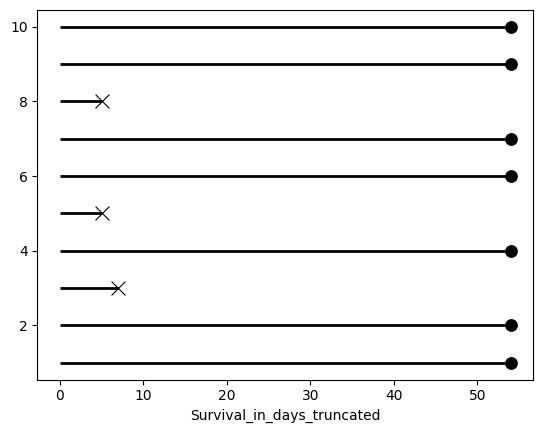

In [7]:
# Dataframe with markers
status_data= pd.DataFrame(y)
status_data['marker']= status_data['Status'].map({False:'o',True:'x'})

# Truncate to make it more fancy
max_death= max(status_data[status_data['Status'] == True]['Survival_in_days'])
status_data['Survival_in_days_truncated']= status_data['Survival_in_days']
status_data.loc[status_data['Survival_in_days_truncated'] > 54, 'Survival_in_days_truncated'] = 54


# Select a random sample to make it more fancy
sample= [1,2,3,4,5,6,7,8,9,10]
sample_data= status_data.iloc[sample,]

# Plot results
for x in sample_data.marker.unique():
    t= sample_data.loc[sample_data['marker']==x]
    g= sns.scatterplot(data=t, x='Survival_in_days_truncated', y=t.index.tolist(), marker=x, s=100, color='black')

for index, row in sample_data.iterrows():
    g.hlines(y=index, xmin=0, xmax=row['Survival_in_days_truncated'], linewidth=2, color='black')

### 3. Kaplan-Meier estimator

With the variables *Status* and *Survival_in_days*, it is possible to define the **survival function** ($S(t)$), which returns the probability of survival beyond a time $t$: $S(t) = P(T>t)$. If there are no censoring, $S(t)= \frac{PatientsSurvivedtot}{TotalNumberOfPatients}$.

If there are right censoring, ***Kaplan-Meier estimator*** is a valid method to calculate survival function. This function is a step function, whose steps are time points where one or more patients died.

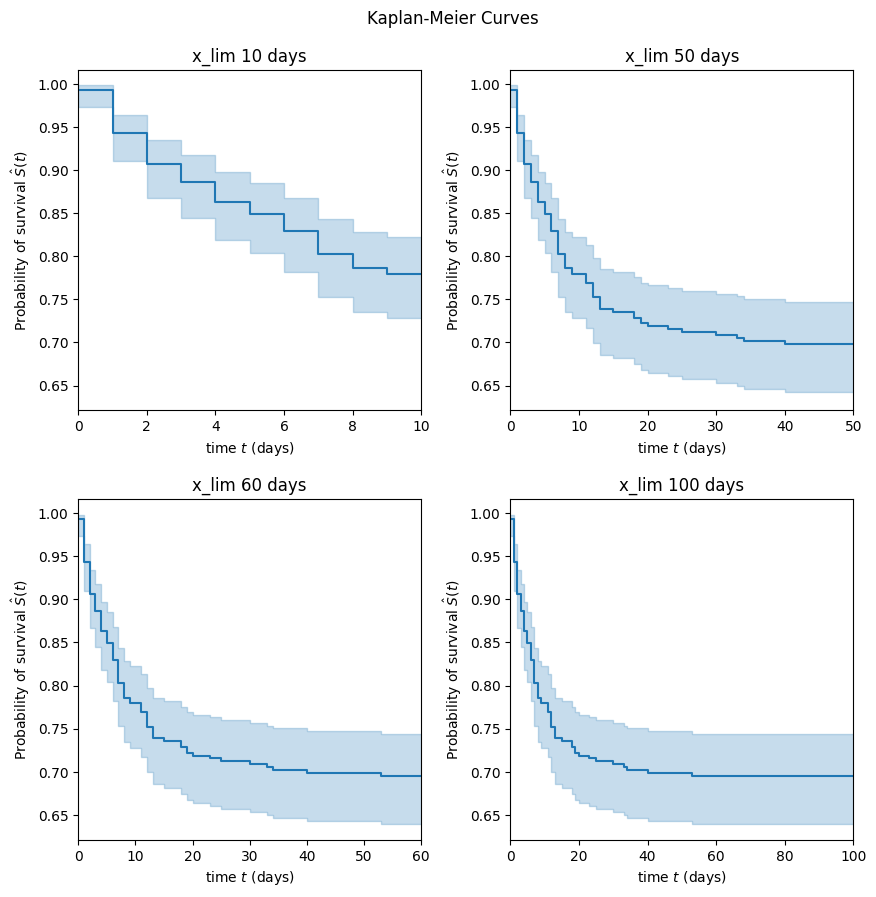

In [8]:
#time, survival_prob= kaplan_meier_estimator(Status, Survival_in_days)

fig, axs= plt.subplots(2,2, figsize=(10,10))
fig.suptitle('Kaplan-Meier Curves', fontsize=12, y=0.94)

lim= [10,50,60,100]
counter= 0
for i in range(2):
    for j in range(2):
        #axs[i,j].step(time, survival_prob, where='post')
        KaplanMeierFitter().fit(Survival_in_days, Status).plot(ax=axs[i,j])
        axs[i,j].get_legend().remove()

        axs[i,j].set_title('x_lim ' + str(lim[counter]) + ' days')
        axs[i,j].set_ylabel('Probability of survival $\hat{S}(t)$')
        axs[i,j].set_xlabel('time $t$ (days)')
        axs[i,j].set_xlim([0,lim[counter]])
        counter+=1
        
plt.subplots_adjust(hspace=0.26, wspace=0.26)

### 3.1. Mantel-Cox test (Log-rank)

In survival analysis, ***Mantel-Cox test***, also known as ***log rank***, is a statistical technique for comparing survival functions. It is a **non-parametric** test based on the *Chi-square test* that can be used in presence of censored data.

In [9]:
# Define a log rank test function
def logrank(y, df, variable, decimals, counts=False):
    
    idx_nan= np.isnan(pd.to_numeric(df[variable])) # exclude nan
    lk_result= compare_survival(y=y[~idx_nan], group_indicator=df[variable][~idx_nan], return_stats=True)
    p_value= round(lk_result[1], decimals)
    
    if counts == True: print(lk_result[2])
    
    return(p_value)

*Log rank test* is the appropriate statistical technique to compare *survival functions*. In biostatistics, usually the grouping variables are qualitative, since transforming a quantitative variable into categorical by making intervals in order to separate *survival functions*, is not considered a good practice when talking about *survival functions* and *logrank*.

In [10]:
cat_predictors= df_metadata[(df_metadata['Pandas_Datatype'] == 'category') &
                            (df_metadata['Type_of_Variable'].str.contains('Predictor'))]['Variable_Label'].values.tolist()

In [11]:
# Do the logrank tests
p_value_logrank= [logrank(y=y, df=df, variable=cat_predictor, decimals=4, counts=False)
                                for cat_predictor in cat_predictors]

# Adjust p.values by FDR
p_adj_logrank= fdrcorrection(np.array(p_value_logrank), method='indep', is_sorted=False)[1]

# Build a dataframe
p_adj_logrank= pd.DataFrame(data={'variable':cat_predictors,
                                  'p_value':p_value_logrank,
                                  'p_adj_fdr':np.round(p_adj_logrank,4)})

# Filter by significant tests
alpha_logrank= 0.05
significative_logrank= p_adj_logrank[p_adj_logrank['p_adj_fdr'] < alpha_logrank]
significative_logrank

,variable,p_value,p_adj_fdr
9,carrhythmias,0.0040,0.0356
24,arbs,0.0017,0.0272
45,dabigatran,0.0000,0.0000
53,mh_le_trauma,0.0073,0.0487
55,other_symptoms,0.0030,0.0343
56,neurol_signs,0.0049,0.0392
58,anisocoria,0.0000,0.0000
61,altered_consciousness,0.0000,0.0000
70,tgcs,0.0000,0.0000
71,primary_ich,0.0023,0.0307


Sometimes, *correction of p-values* are too conservative. Thus, sometimes it is useful to see the associations which are near the significance.

In [12]:
# Associations which were significant at the beggining, but FDR correction turn them into non-significant
near_sig_logrank= p_adj_logrank[(p_adj_logrank['p_value'] < alpha_logrank) & (p_adj_logrank['p_adj_fdr'] > alpha_logrank)]
near_sig_logrank

,variable,p_value,p_adj_fdr
10,structural_heart_disease,0.0104,0.0530
30,diuretics,0.0214,0.1007
33,sulfonylureas,0.0099,0.0530
43,cumarinics,0.0106,0.0530
52,mh_trauma,0.0097,0.0530
67,rlwlimb_mimpairment,0.0280,0.1244


#### 3.1.1. Check for counts

Checking for counts is a good practice to be sure that results are reliable.

In [13]:
# Check for counts
sig_or_near_sig= significative_logrank['variable'].tolist() + near_sig_logrank['variable'].tolist()

for sig in sig_or_near_sig:
    print('\n', sig)
    logrank(y=y, df=df, variable=sig, decimals=4, counts=True)


 carrhythmias
       counts  observed   expected  statistic
group                                        
0         235        62  72.833398 -10.833398
1          65        29  18.166602  10.833398

 arbs
       counts  observed   expected  statistic
group                                        
0         257        69  79.022126 -10.022126
1          43        22  11.977874  10.022126

 dabigatran
       counts  observed   expected  statistic
group                                        
0         298        89  90.885657  -1.885657
1           2         2   0.114343   1.885657

 mh_le_trauma
       counts  observed   expected  statistic
group                                        
0.0       189        68  55.680655  12.319345
1.0       110        23  35.319345 -12.319345

 other_symptoms
       counts  observed   expected  statistic
group                                        
0.0       137        52  38.247243  13.752757
1.0       161        38  51.752757 -13.752757

 neurol_sign

#### 3.1.2. Visualization

Visualization of statistical results is often a must. Algought hypothesis contrasts are objetive whereas visualization assements are subjective, plots can sometimes give a further perspective than hypothesis tests do.

In [14]:
# Define a function to get separated survival functions by group
def kaplan_meier_comp (df, group, groups, status, survival):
    
    group1= df[df[group] == groups[0]]
    group2= df[df[group] == groups[1]]
    
    Status1= np.array(group1[status] == 0)
    Survival_in_days1= np.array(group1[survival])
    
    Status2= np.array(group2[status] == 0)
    Survival_in_days2= np.array(group2[survival])
    
    time1, survival_prob1= kaplan_meier_estimator(Status1, Survival_in_days1)
    time2, survival_prob2= kaplan_meier_estimator(Status2, Survival_in_days2)
    
    functions= [(time1, survival_prob1), (time2, survival_prob2)]
    
    return (functions)

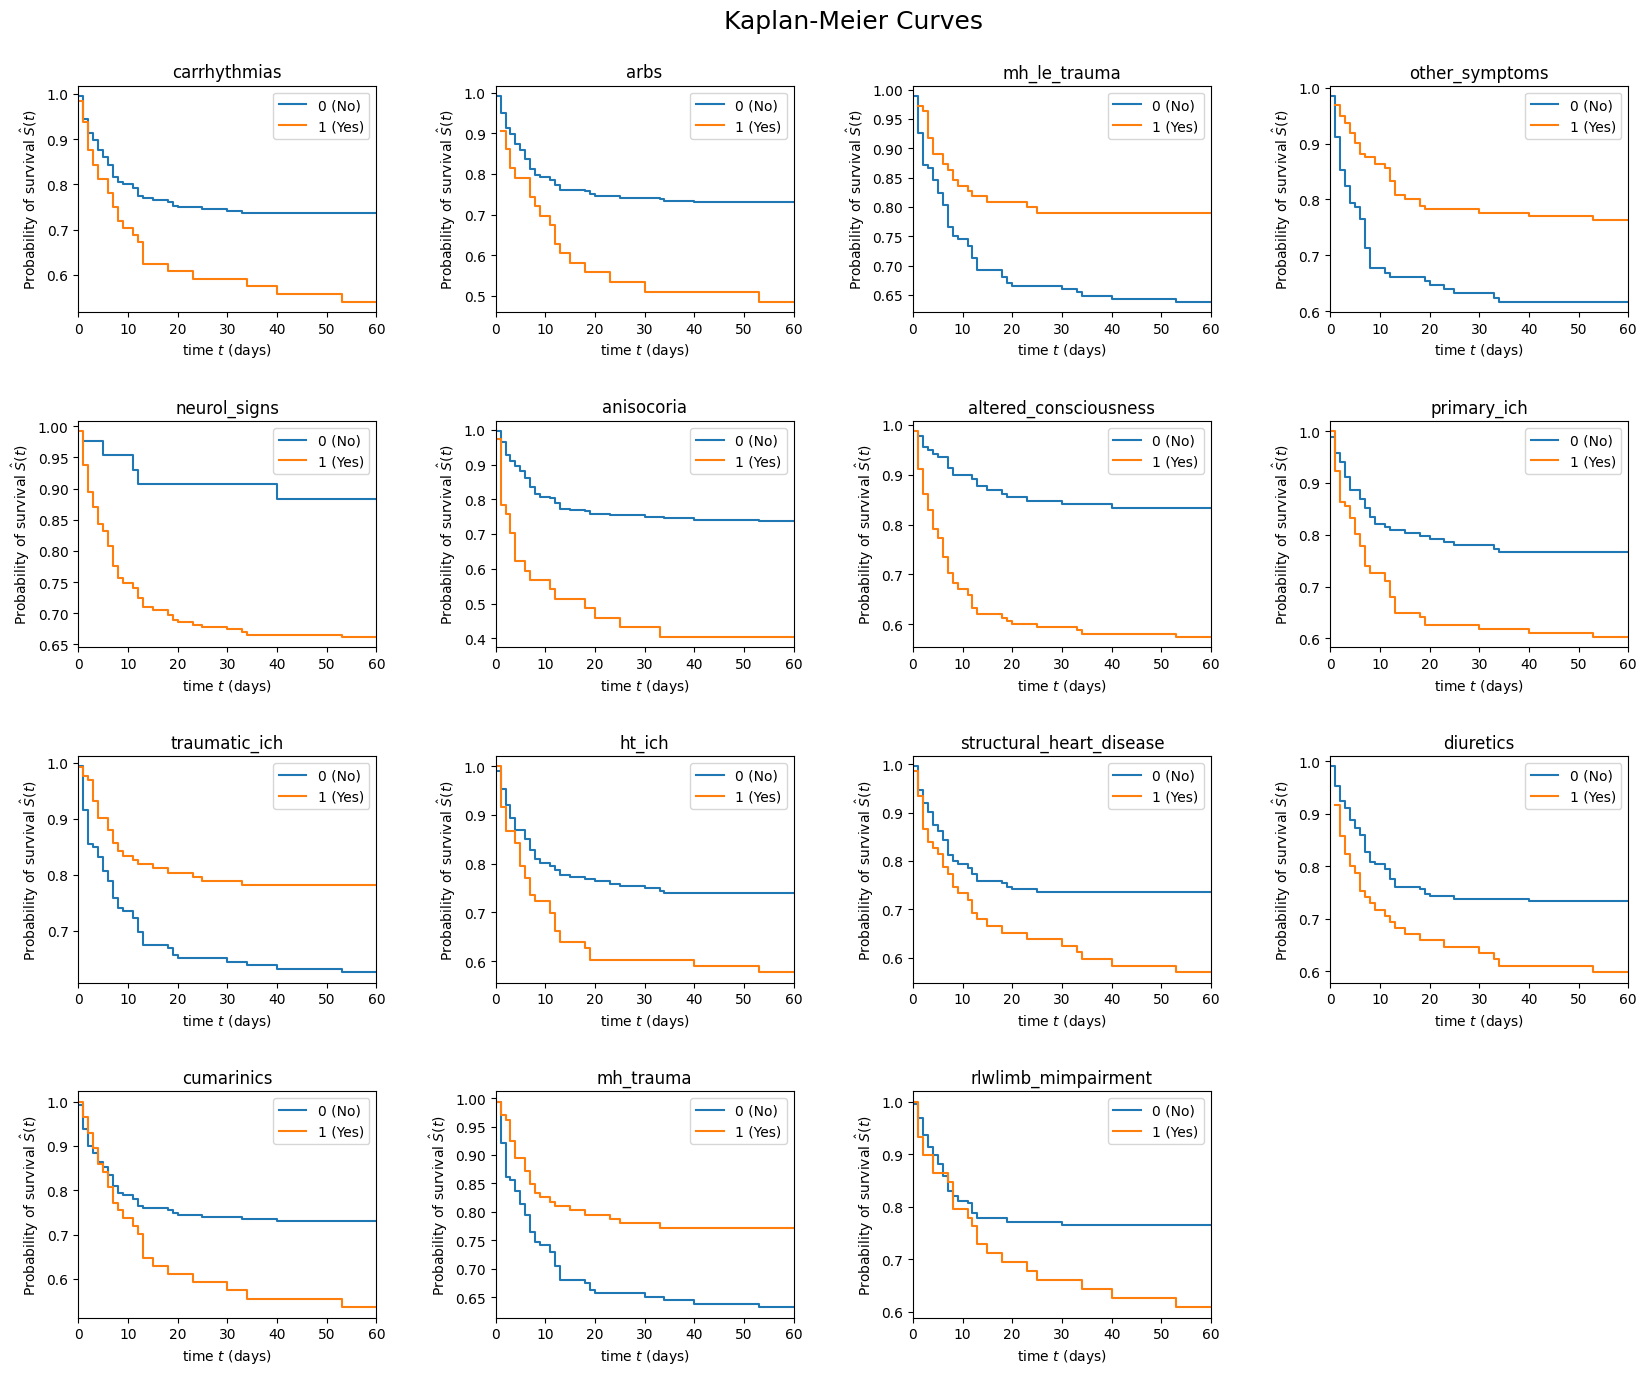

In [15]:
groups= sig_or_near_sig[:]
groups.remove('tgcs') # Delete non-binary variables
groups.remove('dabigatran') # Delete variables without enough n in one group
groups.remove('sulfonylureas')

fig= plt.figure(figsize=(20,16))
plt.title('Kaplan-Meier Curves', fontsize=18, y=1.04)
plt.axis('off')


counter= 1
for group in groups:
    functions= kaplan_meier_comp (df, group, (0,1), status='survival_discharge', survival='survival_days')
    
    ax= fig.add_subplot(4,4, counter)
    ax.step(functions[0][0], functions[0][1], where='post', label='0 (No)')
    ax.step(functions[1][0], functions[1][1], where='post', label='1 (Yes)')
    
    ax.set_title(group)
    ax.set_ylabel('Probability of survival $\hat{S}(t)$')
    ax.set_xlabel('time $t$ (days)')
    ax.set_xlim([0,60])
    ax.legend()
    counter+=1
        
plt.subplots_adjust(hspace=0.48, wspace=0.4)

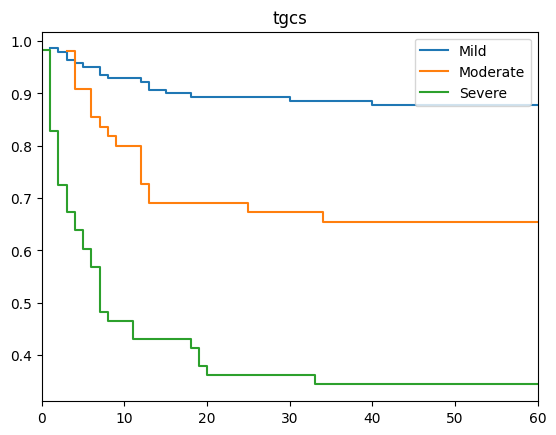

In [16]:
df['tgcs2']= pd.to_numeric(df['tgcs'])

Status1= np.array(df[df['tgcs2'] > 12]['survival_discharge'] == 0)
Status2= np.array(df[(df['tgcs2'] >= 8) & (df['tgcs2'] <= 12)]['survival_discharge'] == 0)
Status3= np.array(df[df['tgcs2'] < 8]['survival_discharge'] == 0)
    
Survival_in_days1= np.array(df[df['tgcs2'] > 12]['survival_days'])
Survival_in_days2= np.array(df[(df['tgcs2'] >= 8) & (df['tgcs2'] <= 12)]['survival_days'])
Survival_in_days3= np.array(df[df['tgcs2'] < 8]['survival_days'])
    
time1, survival_prob1= kaplan_meier_estimator(Status1, Survival_in_days1)
time2, survival_prob2= kaplan_meier_estimator(Status2, Survival_in_days2)
time3, survival_prob3= kaplan_meier_estimator(Status3, Survival_in_days3)


fig= plt.figure()

plt.step(time1, survival_prob1, where='post', label='Mild')
plt.step(time2, survival_prob2, where='post', label='Moderate')
plt.step(time3, survival_prob3, where='post', label='Severe')

plt.title('tgcs')
plt.xlim([0,60])
plt.legend()

### 4. Cox regression

*Kaplan-Meier estimator* and *log rank tests* are *univariate* analysis which do not work easily for quantitative predictors. Therefore, there is a need of a statistical technique able to do **multivariate survival analysis** and able to manage with **quantitative predictors**. This technique is ***Cox proportional hazard's regression***. ***Hazard*** is the slope of the survival curve. It measures how rapidly subjects are dying. ***Hazard ratio*** is a ratio of hazards, so it says how many times are the risk of death in one group compared to each other. 

<center>$h(t|xᵢ)=h₀(t)exp(β'xᵢ)$</center>

 - $h(t|xᵢ)$: **hazard function**
 - $h₀(t)$: **baseline hazard function**: risk without the intervention of risk factors.
 - $exp(β'xᵢ)$: **relative risks or hazard ratios**: risk added by risk factors.

*Cox regression* is based on ***hazard ratios***, which are risks of an event (death). The assumptions of *Cox model* includes:
   - Independence of survival times between distinct individuals in the sample.
   - A multiplicative relationship between the predictors and the hazard.
   - A constant hazard ratio over time.

Data have to be convert into numeric.

In [17]:
df_numeric= df.apply(pd.to_numeric)

#### 4.1. Study of predictors

Before starting with *Cox regression*, it is possible to fit a single and **univariate** regression for each feature, to explore which single variable is the best risk predictor. 

In [18]:
# Delete non-useful columns
cols= df_numeric.columns.tolist()
cols.remove('patient')
cols.remove('survival_discharge')
cols.remove('survival_days')
cols.remove('time_between_CT_bloodanalysis')
cols.remove('tgcs2')

df_numeric= df_numeric[cols]

In [19]:
# Define a Cox regression function
def fit_and_score_features(df_numeric, y):

    n_features= df_numeric.shape[1]
    scores= np.empty(n_features)
    cox_reg= CoxPHSurvivalAnalysis()
    
    for idx_feature in range(n_features):
        
        X= df_numeric[:,idx_feature]
        idX_nan= np.isnan(X) # exclude nan
        X2= X[~idX_nan,].reshape(-1, 1)
        y2= y[~idX_nan,]
        
        cox_reg.fit(X2, y2)
        scores[idx_feature]= cox_reg.score(X2, y2)

    return scores

In [20]:
# Fit one regression per variable, and order the results
scores= pd.DataFrame(data={'score':fit_and_score_features(df_numeric.values,y)},
                     index= df_numeric.columns).sort_values(by='score', ascending=False)

In [21]:
round(scores[(scores['score'] > 0.6) & (scores.index.str.contains('surviv') == False)],2)

,score
final_outcome,0.90
follow_up,0.89
hospitalization_days,0.82
tgcs,0.78
hospitalizations_5y,0.74
hospitalizations_3y,0.71
glucose,0.66
inr,0.64
altered_consciousness,0.63
onset_h,0.63


#### 4.2. Simple Cox regression

This previous analysis is useful to select the most relevant variables and fit a multivariant *Cox regression*.

In [22]:
cox_variables= ['hospitalization_days', 'tgcs', 'glucose', 'inr', 'altered_consciousness', 'onset_h', 'prothrombin_activity']

Training a *regression* does not require to do a **cross-validation**, nonetheless it is a good technique to calculate a confidence interval for the accuracy, specially when dataset size is limited. Concerning the evaluation, metrics like MSE (quantitative predictions, regression) or accuracy (qualitative predictions, classification) do not work with survival data, since survival analysis adds one more layer of complexity, the censored data. In this cases, the metrics called **Harrell’s concordance index** or **c-index**, and **Uno’s c**, are the appropriate metrics to use. The second one is a modification of the first one, and it works better in presence of higher amount of censoring. It is an alternative to *Harrell’s concordance index* that does not depend on the distribution of censoring times in the test data.

In [23]:
# Define a function to do K-fold cross validation and calculate c-indexs
def cross_validation (x,y,k):
    
    idx= list(range(x.shape[0]))
    size= x.shape[0]/k
    x_, y_= shuffle(x,y) # shuffle to take random folds
    scores1= []
    scores2= []
    
    for fold in range(k):
        idx_test= list(range(int(fold*size),int((fold+1)*size)))
        idx_train= list(set(idx) - set(idx_test))
        
        cox_reg= CoxPHSurvivalAnalysis()
        cox_reg.fit(x_.values[idx_train,], y_[idx_train])
        
        score1= cox_reg.score(x_.values[idx_test], y_[idx_test]) # c-index
        prediction= cox_reg.predict(x_.values[idx_test])
        score2= concordance_index_ipcw(y_[idx_train], y_[idx_test], prediction) # Uno's c-index
        
        scores1.append(score1)
        scores2.append(score2[0])

    return (scores1, scores2)

In [24]:
cox_vars= df_numeric[cox_variables] # select variables
idx_nan= cox_vars.isna().any(axis=1) # exclude NaN
cox_vars= cox_vars[~idx_nan]
y_vars= y[~idx_nan]

cox_reg1_hc, cox_reg1_uc= cross_validation (x=cox_vars, y=y_vars, k=10)
cox_reg2_hc, cox_reg2_uc= cross_validation (x=cox_vars.iloc[:,1:], y=y_vars, k=10) # exclude days of hospitalization

print('Model1 (index-c):    ', round(np.mean(cox_reg1_hc),4), '±', round(np.std(cox_reg1_hc),4))
print('Model1 (index-c uno):', round(np.mean(cox_reg1_uc),4), '±', round(np.std(cox_reg1_uc),4))

print('Model2 (index-c):    ', round(np.mean(cox_reg2_hc),4), '±', round(np.std(cox_reg2_hc),4))
print('Model2 (index-c uno):', round(np.mean(cox_reg2_uc),4), '±', round(np.std(cox_reg2_uc),4))

Model1 (index-c):     0.8412 ± 0.0768
Model1 (index-c uno): 0.8384 ± 0.0799
Model2 (index-c):     0.767 ± 0.1149
Model2 (index-c uno): 0.7668 ± 0.1158


The final model is **very interpretable**, as coefficients the exp($\beta$i) is the **hazard ratio** of each factor for the event.
 
   - $\beta$ > 0: hazard ratio > 1, increased risk of event (death).
   - $\beta$ < 0: hazard ratio < 1, reduced risk of event.

It is useful to transform coeficients, into **hazard ratios**.

In [25]:
cox_reg= CoxPHSurvivalAnalysis()
cox_reg.fit(cox_vars, y_vars) # final model trained with all data
    
pd.DataFrame(data={'Risk factor':cox_variables,
                   'Coefficient [\u03B2]': np.round(cox_reg.coef_,4),
                   'Hazard ratio [exp(\u03B2)]': np.round(np.exp(cox_reg.coef_),4)})

,Risk factor,Coefficient [β],Hazard ratio [exp(β)]
0,hospitalization_days,-0.1003,0.9046
1,tgcs,-0.1857,0.8305
2,glucose,0.0061,1.0061
3,inr,-0.1010,0.9039
4,altered_consciousness,0.1929,1.2127
5,onset_h,-0.0051,0.9949
6,prothrombin_activity,-0.0156,0.9845


#### 4.3. Cox net - regression with elastic net penalty

*Cox regression* model can be improve by adding regularization: **ridge** ($l2$) and **lasso** ($l1$). The resulting objective is a ***penalized Cox model***, often referred to as ***ridge*** or ***lasso regression***. The addition of regularization adds a new hiperparameter which should be optimize $\alpha$. As bigger $\alpha$ as more regularization is applied. If $\alpha$ = 0, the model obtained is the standard *Cox regression*. There is a third approach to regularize the *Cox model*, the ***elastic net penalty***, which combines $l2$ and $l1$ regularizations. The *elastic net penalty* combines the subset selection property of the *lasso* with the regularization strength of the *ridge penalty*. This penalty adds a new hiperparameter $r$, which is the relative weight of the $l2$ and $l1$ regularizations (high $r$ values gives more weight to *lasso*).

###### NOTE

Linear models, like *Cox regression*, do not require to normalize or to standarize the inputs, nervertheless, when adding *lasso* and *ridge* penalization it is a good practice to standarize the inputs. Therefore, a pipeline including feature standarization before *Cox regression* is implemented in the following examples. However, it is needed to be **careful**, since the interpretation of the coefficients changes, they **refered to the standarize variables, and not to the orginal variables**.

#### 4.3.1. Optimization of hyperparameters

   - **Pipeline**: **standarization** + ***Cox net***.
   - Search **best parameters**: $\alpha$, $r$ (*l1_ratio*), and tol (*tolerance*).

In [26]:
# Set fitting data
X_data= cox_vars
y_data= y_vars

#### 4.3.1.1. Alpha ($\alpha$) analysis

In [27]:
# Make a little pipeline just to get alphas generated by the model class
alphas_pipe= make_pipeline(StandardScaler(),
                           CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)).fit(X_data, y_data)

alphas= alphas_pipe.named_steps['coxnetsurvivalanalysis'].alphas_

# Build pipeline, GridSearch and fit
coxnet_alpha_gcv= GridSearchCV(make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
                               param_grid={'coxnetsurvivalanalysis__alphas': [[v] for v in alphas]},
                               cv=KFold(n_splits=5, shuffle=True, random_state=0),
                               error_score=0.5,
                               n_jobs=1).fit(X_data, y_vars)

coxnet_alpha_cv_results= pd.DataFrame(coxnet_alpha_gcv.cv_results_)

We can visualize the results by plotting the *mean concordance index* and its standard deviation across all folds for each 
$\alpha$.

Best α: 0.008133401560621057


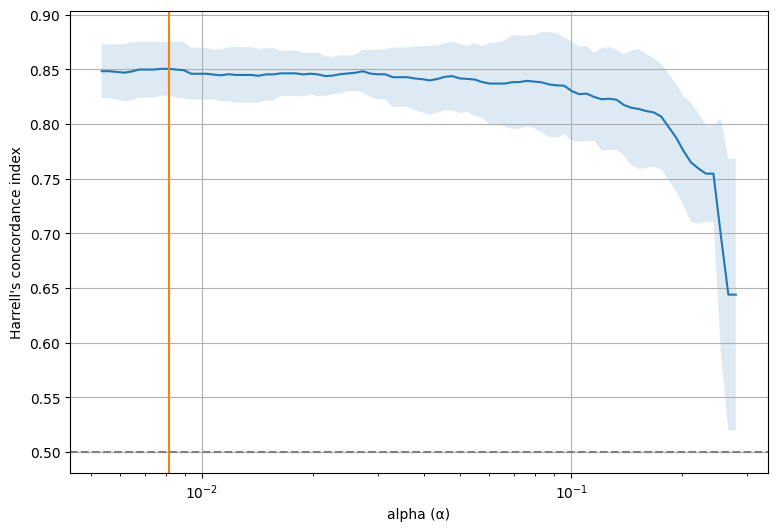

In [28]:
alphas= coxnet_alpha_cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean= coxnet_alpha_cv_results.mean_test_score
std= coxnet_alpha_cv_results.std_test_score

fig, ax= plt.subplots(figsize=(9,6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean-std, mean+std, alpha=.15)
ax.set_xscale('log')
ax.set_ylabel('Harrell\'s concordance index')
ax.set_xlabel('alpha (\u03B1)')
ax.axvline(coxnet_alpha_gcv.best_params_['coxnetsurvivalanalysis__alphas'][0], c='C1')
ax.axhline(0.5, color='grey', linestyle='--')
ax.grid(True)

print('Best \u03B1:', coxnet_alpha_gcv.best_params_['coxnetsurvivalanalysis__alphas'][0])

#### 4.3.1.2. Analysis of all parameters

Searching for more hyperparameters.

In [29]:
# Set fitting data
#X_data= cox_vars
#y_data= y_vars

# Build the pipeline
standarization= StandardScaler()
coxnet= CoxnetSurvivalAnalysis(max_iter=100) # Hyperparameters already fixed

coxnet_pipe= make_pipeline(standarization,coxnet)


# Build de GridSearch
param_grid= {'coxnetsurvivalanalysis__alphas':  [[alpha] for alpha in alphas],
             'coxnetsurvivalanalysis__l1_ratio':[l1_ratio/10 for l1_ratio in range(1,10)],
             'coxnetsurvivalanalysis__tol':     [1e-6,1e-7,1e-8]}

cv= KFold(n_splits=5, shuffle=True, random_state=0)

coxnet_gcv= GridSearchCV(estimator=coxnet_pipe,
                         param_grid=param_grid,
                         cv=cv,
                         error_score=0.5,
                         n_jobs=1)

# Fit the model
t0= time()
coxnet_gcv.fit(X_data, y_data)
tcv= time()-t0

# Summary
print('cv time: %0.3fs'%(tcv))
print('Best parameters:', coxnet_gcv.best_params_)
coxnet_gcv

cv time: 82.420s
Best parameters: {'coxnetsurvivalanalysis__alphas': [0.023709297130475454], 'coxnetsurvivalanalysis__l1_ratio': 0.3, 'coxnetsurvivalanalysis__tol': 1e-08}


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=0.5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('coxnetsurvivalanalysis',
                                        CoxnetSurvivalAnalysis(max_iter=100))]),
             n_jobs=1,
             param_grid={'coxnetsurvivalanalysis__alphas': [[0.27901384246976285],
                                                            [0.26633223271680023],
                                                            [0.2542270216991221],
                                                            [0.24267201120463158],
                                                            [0...
                                                            [0.1152888656888888],
                                                            [0.11004880881362228],
                                                            [0.10504692061051639],
                                                            [0.10027237594584663],
                                                            [0.09571484170492311],
                                                            [0.09136445442906611],
                                                            [0.08721179896901553],
                                                            [0.0832478881085759],
                                                            [0.07946414311439817],
                                                            [0.07585237516980388],
                                                            [0.07240476765247071], ...],
                         'coxnetsurvivalanalysis__l1_ratio': [0.1, 0.2, 0.3,
                                                              0.4, 0.5, 0.6,
                                                              0.7, 0.8, 0.9],
                         'coxnetsurvivalanalysis__tol': [1e-06, 1e-07, 1e-08]})

In [30]:
# Results
coxnet_cv_results= pd.DataFrame(coxnet_gcv.cv_results_)
coxnet_cv_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_coxnetsurvivalanalysis__alphas,param_coxnetsurvivalanalysis__l1_ratio,param_coxnetsurvivalanalysis__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004769,0.000916,0.002320,0.000438,[0.27901384246976285],0.1,0.000001,{'coxnetsurvivalanalysis__alphas': [0.27901384...,0.881789,0.828283,0.796154,0.847953,0.813333,0.833502,0.029561,1891
1,0.003849,0.000028,0.001943,0.000075,[0.27901384246976285],0.1,0.0,{'coxnetsurvivalanalysis__alphas': [0.27901384...,0.881789,0.828283,0.796154,0.847953,0.813333,0.833502,0.029561,1891
2,0.003893,0.000147,0.001963,0.000091,[0.27901384246976285],0.1,0.0,{'coxnetsurvivalanalysis__alphas': [0.27901384...,0.881789,0.828283,0.796154,0.847953,0.813333,0.833502,0.029561,1891


#### 4.3.2. Analysis of the best model

In [31]:
# Harrell's c-index
best_coxnet_mean_cindex, best_coxnet_std_cindex= coxnet_cv_results[coxnet_cv_results['rank_test_score'] == 1][['mean_test_score', 'std_test_score']].values[0]

print('Model c-index:', np.round(best_coxnet_mean_cindex,4), '±', np.round(best_coxnet_std_cindex,4))

Model c-index: 0.8545 ± 0.0168


In [32]:
# Obtain best coefficients
best_coxnet= coxnet_gcv.best_estimator_.named_steps['coxnetsurvivalanalysis']

best_coefs= pd.DataFrame(best_coxnet.coef_, index=X_data.columns, columns=['coefficient'])
best_coefs['hazard ratio [exp(\u03B2)]']= np.exp(best_coxnet.coef_)
round(best_coefs,4)

,coefficient,hazard ratio [exp(β)]
hospitalization_days,-1.0829,0.3386
tgcs,-0.6658,0.5138
glucose,0.3166,1.3725
inr,-0.0469,0.9542
altered_consciousness,0.1373,1.1471
onset_h,-0.3649,0.6942
prothrombin_activity,-0.3375,0.7135


Number of non-zero coefficients: 7


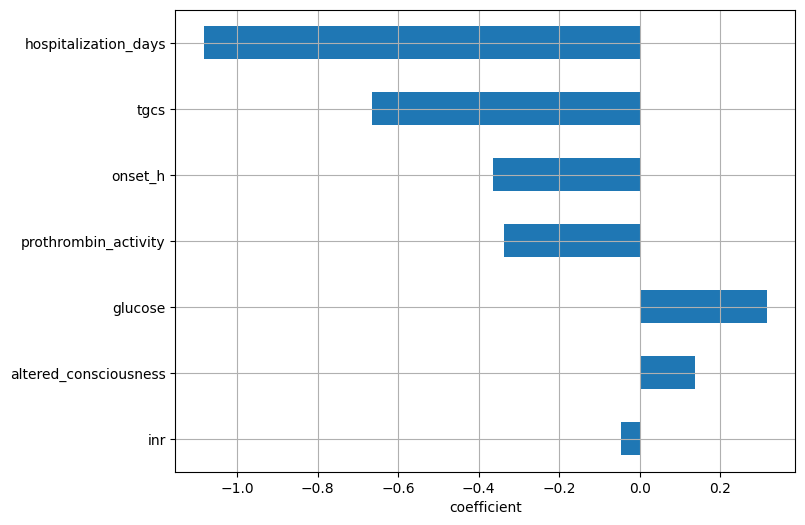

In [33]:
# Select non-zero coefficients
non_zero= np.sum(best_coefs.iloc[:,0] != 0)
print('Number of non-zero coefficients: {}'.format(non_zero))

non_zero_coefs= best_coefs.query('coefficient != 0')
coef_order= non_zero_coefs.abs().sort_values('coefficient').index

# Plot non-zero coefficients
_, ax= plt.subplots(figsize=(8,6))
non_zero_coefs.loc[coef_order,'coefficient'].plot.barh(ax=ax, legend=False)
ax.set_xlabel('coefficient')
ax.grid(True)

#### 4.3.3. Repeat excluding days of hospitalization 

cv time: 79.860s
Best parameters: {'coxnetsurvivalanalysis__alphas': [0.07240476765247071], 'coxnetsurvivalanalysis__l1_ratio': 0.7, 'coxnetsurvivalanalysis__tol': 1e-06}
Model c-index: 0.7907 ± 0.7907
Number of non-zero coefficients: 3


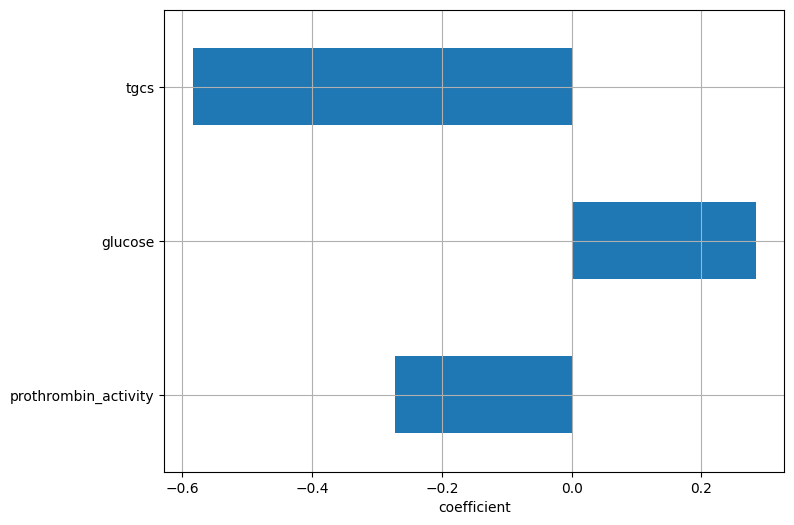

In [34]:
# Set fitting data
X_data2= cox_vars.iloc[:,1:] # remove hospitalization days
y_data= y_vars

coxnet2_gcv= GridSearchCV(estimator=coxnet_pipe,
                          param_grid=param_grid,
                          cv=cv,
                          error_score=0.5,
                          n_jobs=1)

# Fit the model
t0= time()
coxnet2_gcv.fit(X_data2, y_data)
tcv2= time()-t0

# Summary
print('cv time: %0.3fs'%(tcv2))
print('Best parameters:', coxnet2_gcv.best_params_)


# Results
coxnet2_cv_results= pd.DataFrame(coxnet2_gcv.cv_results_)

# Harrell's c-index
best_coxnet2_mean_cindex, best_coxnet2_std_cindex= coxnet2_cv_results[coxnet2_cv_results['rank_test_score'] == 1][['mean_test_score', 'std_test_score']].values[0]
print('Model c-index:', np.round(best_coxnet2_mean_cindex,4), '±', np.round(best_coxnet2_mean_cindex,4))

# Coefficients
best_coxnet2= coxnet2_gcv.best_estimator_.named_steps['coxnetsurvivalanalysis']

best_coefs2= pd.DataFrame(best_coxnet2.coef_, index=X_data2.columns, columns=['coefficient'])
best_coefs2['hazard ratio [exp(\u03B2)]']= np.exp(best_coxnet2.coef_)
round(best_coefs2,4)

# Select non-zero coefficients
non_zero2= np.sum(best_coefs2.iloc[:,0] != 0)
print('Number of non-zero coefficients: {}'.format(non_zero2))

non_zero_coefs2= best_coefs2.query('coefficient != 0')
coef_order2= non_zero_coefs2.abs().sort_values('coefficient').index

# Plot non-zero coefficients
_, ax= plt.subplots(figsize=(8,6))
non_zero_coefs2.loc[coef_order2,'coefficient'].plot.barh(ax=ax, legend=False)
ax.set_xlabel('coefficient')
ax.grid(True)

#### 4.3.4. Predictions: Survival and Cumulative Hazard Function

Finally, having selected the optimal hyperparameters, it is posible to perform predictions:
 - In terms of **risk score** (predict function).
 - In terms of **survival** or **cumulative hazard function**. 

In [35]:
# To make predictions, set fit_baseline_model=True
coxnet_pred= make_pipeline(StandardScaler(),
                           CoxnetSurvivalAnalysis(fit_baseline_model=True))

coxnet_pred.set_params(**coxnet_gcv.best_params_) # optimal hyperparameters
coxnet_pred.fit(X_data, y_data)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.023709297130475454],
                                        fit_baseline_model=True, l1_ratio=0.3,
                                        tol=1e-08))])

In [36]:
# Predict a patient
patient=0
pred= coxnet_pred.predict_survival_function(X_data.iloc[[patient,]])